# NLP Milestone 1
A notebook to preprocess youtube transcripts of Al Mokhbir Al Eqtsadi episodes.

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import pyarabic.araby as araby
from nltk.corpus import stopwords
import nltk
from typing import List
from tqdm.notebook import tqdm

### 1. Data Loading

In [2]:
def read_episodes_files(file_path: str) -> pd.DataFrame:
    """
    Read all the episodes files in the file_path and return a DataFrame with the content of the files.
    """
    episodes_files = []
    for file in os.listdir(file_path):
        if file.endswith(".txt"):
            with open(file_path + file, 'r') as f:
                episodes_files.append(f.read())
    df = pd.DataFrame(episodes_files, columns=['episode_transcript'])
    return df

In [3]:
df = read_episodes_files('Al_Mokhbir_Al_Eqtisadi/raw_data/')
df.head()

episode_transcript
0  ايران واذربيجان بينهم حدود طولها يتجاوز\nال 75...
1  قطاع غزه بيتعرض في الاسابيع الاخيره\nلعدوان اج...
2  الدول الغربية بقيادة الولايات المتحدة\nمستمرة ...
3  في 8 اكتوبر 2023 وبعد يوم واحد من انطلاق\nعملي...
4  في 26 يناير سنه 1968 صحيفه انترناشونال\nهيرال ...

### 2. Data Understanding

In [4]:
# View number of samples
df.shape

(222, 1)

In [5]:
# View average transcript length 
df['episode_transcript'].apply(len).mean()

14161.801801801801

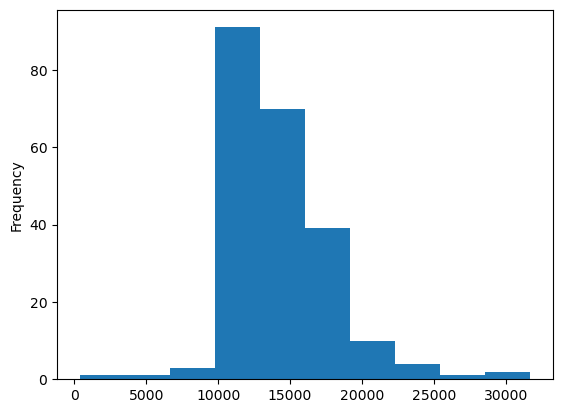

In [6]:
# View the histogram of transcript lengths
df['episode_transcript'].apply(len).plot(kind='hist')
plt.show()

In [7]:
# View average transcript word count
int(df['episode_transcript'].apply(lambda x: len(x.split())).mean())

2511

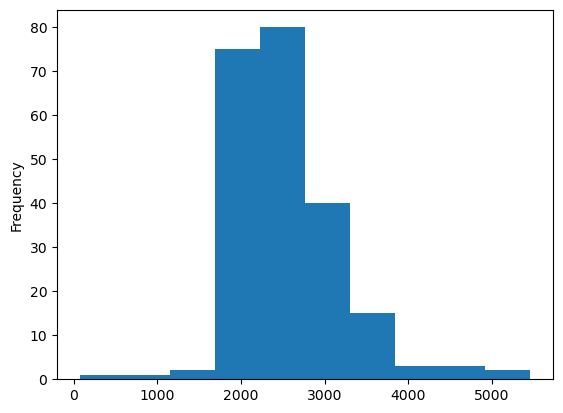

In [8]:
# View the histogram of transcript word count
df['episode_transcript'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.show()

In [9]:
# View a couple of samples
print(df.values[0][0])

ايران واذربيجان بينهم حدود طولها يتجاوز
ال 750 ك م الرئيس الايراني الراحل
ابراهيم رئيسي والرئيس الاذربيجاني الهام
عليف الاثنين اتفقوا ورتبوا مع بعض انهم
يتقابلوا مع بعض يوم 19 مايو 2024 في
منطقه ما على الحدود ما بينهم علشان
يفتتحه سد قيس قلعه سي لتوليد الطاقه
الكهرومائيه اللي تم بناءه على نهر اراس
هيوفر ميه وكهرباء لايران واذربيجان
الاثنين اتقابلوا بالفعل في اليوم ده على
الحدود وافتتحوا السد وبعدين كل واحد فيهم
اخد الناس اللي معاه واتحرك الرئيس
الاذربيجاني واللي معاه وصلوا بلدهم
بالسلامه والوفد الايراني اللي كان راكب
على متن ثلاث طيارات هليكوبتر وصل هو كمان
بالسلامه باستثناء طياره واحده وهي
الطياره اللي كان على متنها تسع اشخاص على
راسهم الرئيس الايراني ابراهيم رئيسي
ووزير الخارجيه الايراني حسين امير عبد
اللهيان الطياره اختفت الساعه ده الظهر
والاتصال اتقطع بيه والعالم كله ما عفش
عنها اي حاجه غير ثاني يوم الصبح لما تم
العثور عليها محطمه وسط الغابات شمال غرب
ايران حاله من الصدمه والمفاجاه سيطره على
ناس كتير من ساعه وقوع الحادثه دي وفي
الاطار ده في تساؤلات كتير بتدور في اذهان
الناس اولها ط

In [10]:
# Check if there are any missing values
df.isna().sum()

episode_transcript    0
dtype: int64

In [11]:
# Check if there are any duplicates
df.duplicated().sum()

0

In [12]:
# Check if there are very short or very long transcripts
df['transcript_length'] = df['episode_transcript'].apply(len)
df['transcript_length'].describe()

count      222.000000
mean     14161.801802
std       3645.946027
min        370.000000
25%      11721.250000
50%      13418.500000
75%      16070.500000
max      31704.000000
Name: transcript_length, dtype: float64

<Axes: ylabel='Frequency'>

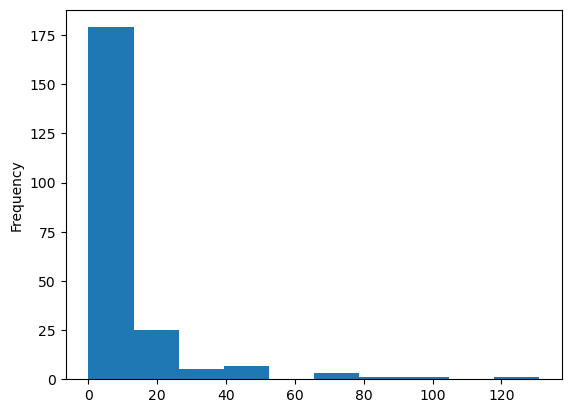

In [13]:
def count_non_arabic_words(text: str) -> int:
    """
    Count the number of non-arabic words in a text, that are also not a number
    """
    non_arabic_words = 0
    for word in text.split():
        if re.search(r'[a-zA-Z]', word):
            non_arabic_words += 1
    return non_arabic_words

# Apply the function on the DataFrame
df['non_arabic_words_count'] = df['episode_transcript'].apply(count_non_arabic_words)

# Plot the distribution of non-arabic words
df['non_arabic_words_count'].plot(kind='hist')

It can seen from the histogram that `Al Mokhbir Al Eqtisadi` uses small number of english phrases in his episodes

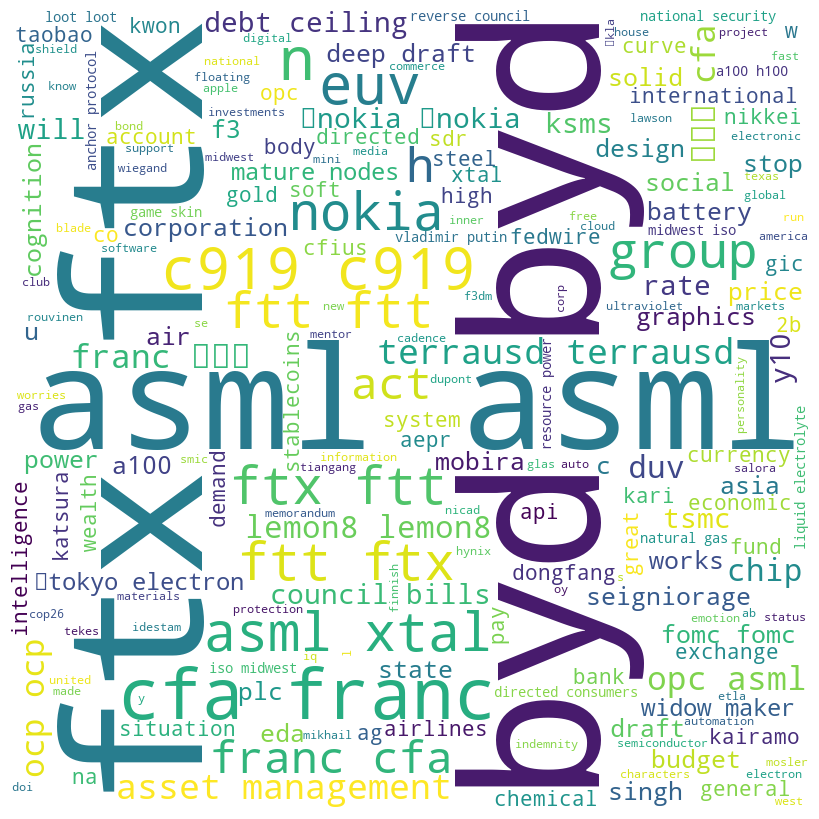

In [14]:
# Plot word cloud for the most common non-arabic words
from wordcloud import WordCloud

# Create a word cloud for the most common non-arabic words
non_arabic_words = ' '.join(df['episode_transcript'].apply(lambda x: ' '.join([word.lower() for word in x.split() if re.search(r'[a-zA-Z]', word)])))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(non_arabic_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

It can be seen from the above word cloud that most of the english phrases used are
1. Company Names
2. Country Names
3. Buisness Expressions 
and others

### 3. Data Preprocessing & Cleaning

In [15]:
# Cleaning function
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def clean_arabic_txt(text: str) -> str:
    """
    Clean the Arabic text by removing any non-Arabic characters, special tags, timestamps, and stopwords.
    """
    text = re.sub(r'\[\d{2}:\d{2}:\d{2}\]', '', text)  # Remove timestamps
    text = re.sub(r'\[.*?\]', '', text) # Remove special tags like [موسيقى], [ضحك], etc.
    text = re.sub(r'\d+', '', text)     # Remove dates  and numbers
    text = araby.strip_tashkeel(text) 
    text = araby.strip_tatweel(text) 
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text

# Apply the cleaning function
df['cleaned_transcript'] = df['episode_transcript'].apply(clean_arabic_txt)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


episode_transcript  transcript_length  \
0  ايران واذربيجان بينهم حدود طولها يتجاوز\nال 75...              20307   
1  قطاع غزه بيتعرض في الاسابيع الاخيره\nلعدوان اج...              10243   
2  الدول الغربية بقيادة الولايات المتحدة\nمستمرة ...              12473   
3  في 8 اكتوبر 2023 وبعد يوم واحد من انطلاق\nعملي...              17712   
4  في 26 يناير سنه 1968 صحيفه انترناشونال\nهيرال ...              10967   

   non_arabic_words_count                                 cleaned_transcript  
0                       1  ايران واذربيجان بينهم حدود طولها يتجاوز ال الر...  
1                       1  قطاع غزه بيتعرض الاسابيع الاخيره لعدوان اجرامي...  
2                       0  الدول الغربية بقيادة الولايات المتحدة مستمرة م...  
3                       0  اكتوبر وبعد يوم انطلاق عمليه طوفان الاقصى منظم...  
4                       0  سنه صحيفه انترناشونال هيرال ترابيون الامريكيه ...

In [16]:
print(df.values[0][2])

1


#### Tokenization

In [17]:
from farasa.segmenter import FarasaSegmenter

def tokenize(episodes: List[str]) -> List[List[str]]:
    """
    Tokenize a list of Arabic text strings using Farasa and clean the tokens.

    Args:
    - episodes (list of str): List of strings to be tokenized.

    Returns:
    - List of Lists: Cleaned and tokenized text for each episode.
    """
    farasa_segmenter = FarasaSegmenter(interactive=True)

    tokenized_episodes = []    
    for episode in tqdm(episodes):
        segmented_episode = farasa_segmenter.segment(episode)
        episode_split = segmented_episode.split()
        episode_tokenized = []
        for word in episode_split:
            if '+' in word:
                word_split = word.split('+')
                episode_tokenized.extend(word_split)
            else:
                episode_tokenized.append(word)
        tokenized_episodes.append(episode_tokenized)

    return tokenized_episodes


In [18]:
episodes = df['cleaned_transcript'].values.tolist()
cleaned_tokenized = tokenize(episodes=episodes)
df['tokenized_transcript'] = cleaned_tokenized
print(cleaned_tokenized)

[2025-02-23 22:51:05,941 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


  0%|          | 0/222 [00:00<?, ?it/s]

[['إيران', 'و', 'أذربيجان', 'بين', 'هم', 'حدود', 'طول', 'ها', 'يتجاوز', 'ال', 'ال', 'رئيس', 'ال', 'إيراني', 'ال', 'راحل', 'إبراهيم', 'رئيس', 'ي', 'و', 'ال', 'رئيس', 'ال', 'اذربيجاني', 'إلهام', 'عليف', 'ال', 'اثنين', 'اتفق', 'وا', 'و', 'رتب', 'وا', 'ان', 'هم', 'يتقابل', 'وا', 'يوم', 'منطق', 'ه', 'ال', 'حدود', 'بين', 'هم', 'علشان', 'يفتتح', 'ه', 'سد', 'قيس', 'قلع', 'ه', 'سي', 'ل', 'توليد', 'ال', 'طاقه', 'ال', 'كهرومائيه', 'اللي', 'تم', 'بناء', 'ه', 'نهر', 'اراس', 'هيوفر', 'ميه', 'و', 'كهرباء', 'ل', 'إيران', 'و', 'أذربيجان', 'ال', 'اثنين', 'اتقابلوا', 'ب', 'ال', 'فعل', 'ال', 'يوم', 'ده', 'ال', 'حدود', 'و', 'افتتح', 'وا', 'ال', 'سد', 'و', 'بعد', 'ين', 'في', 'هم', 'اخد', 'ال', 'ناس', 'اللي', 'معا', 'ه', 'و', 'اتحرك', 'ال', 'رئيس', 'ال', 'اذربيجاني', 'و', 'اللي', 'معا', 'ه', 'وصل', 'وا', 'بلد', 'هم', 'ب', 'ال', 'سلامه', 'و', 'ال', 'وفد', 'ال', 'إيراني', 'اللي', 'راكب', 'متن', 'طيار', 'ات', 'هليكوبتر', 'وصل', 'كمان', 'ب', 'ال', 'سلامه', 'ب', 'استثناء', 'طيار', 'ه', 'واحد', 'ه', 'و', 'هي', 'ال

In [19]:
df.head()

episode_transcript  transcript_length  \
0  ايران واذربيجان بينهم حدود طولها يتجاوز\nال 75...              20307   
1  قطاع غزه بيتعرض في الاسابيع الاخيره\nلعدوان اج...              10243   
2  الدول الغربية بقيادة الولايات المتحدة\nمستمرة ...              12473   
3  في 8 اكتوبر 2023 وبعد يوم واحد من انطلاق\nعملي...              17712   
4  في 26 يناير سنه 1968 صحيفه انترناشونال\nهيرال ...              10967   

   non_arabic_words_count                                 cleaned_transcript  \
0                       1  ايران واذربيجان بينهم حدود طولها يتجاوز ال الر...   
1                       1  قطاع غزه بيتعرض الاسابيع الاخيره لعدوان اجرامي...   
2                       0  الدول الغربية بقيادة الولايات المتحدة مستمرة م...   
3                       0  اكتوبر وبعد يوم انطلاق عمليه طوفان الاقصى منظم...   
4                       0  سنه صحيفه انترناشونال هيرال ترابيون الامريكيه ...   

                                tokenized_transcript  
0  [إيران, و, أذربيجان, بين, هم, حدود, طول, ها, ي...  
1  [قطاع, غز, ه, ب, يتعرض, ال, أسابيع, ال, اخيره,...  
2  [ال, دول, ال, غربي, ة, ب, قياد, ة, ال, ولاي, ا...  
3  [أكتوبر, و, بعد, يوم, انطلاق, عملي, ه, طوفان, ...  
4  [سن, ه, صحيف, ه, إنترناشونال, هيرال, ترابي, ون...

#### Stemming

In [20]:
from farasa.stemmer import FarasaStemmer

def stem(episodes: List[List[str]]) -> List[List[str]]:
    """
    Stem a list of Arabic tokens using Farasa.

    Args:
    - episodes (list of list of str): List of tokenized strings to be stemmed.

    Returns:
    - List of Lists: Stemmed text for each episode.
    """
    farasa_stemmer = FarasaStemmer(interactive=True)

    stemmed_episodes = []
    for episode in tqdm(episodes):
        stemmed_episode = []
        for word in episode:
            stemmed_word = farasa_stemmer.stem(word)
            stemmed_episode.append(stemmed_word)
        stemmed_episodes.append(stemmed_episode)

    return stemmed_episodes

In [21]:
episodes = df['tokenized_transcript'].values.tolist()
stemmed_tokenized = stem(episodes)
df['stemmed_transcript'] = stemmed_tokenized
df.head()

[2025-02-23 22:51:36,323 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


  0%|          | 0/222 [00:00<?, ?it/s]

episode_transcript  transcript_length  \
0  ايران واذربيجان بينهم حدود طولها يتجاوز\nال 75...              20307   
1  قطاع غزه بيتعرض في الاسابيع الاخيره\nلعدوان اج...              10243   
2  الدول الغربية بقيادة الولايات المتحدة\nمستمرة ...              12473   
3  في 8 اكتوبر 2023 وبعد يوم واحد من انطلاق\nعملي...              17712   
4  في 26 يناير سنه 1968 صحيفه انترناشونال\nهيرال ...              10967   

   non_arabic_words_count                                 cleaned_transcript  \
0                       1  ايران واذربيجان بينهم حدود طولها يتجاوز ال الر...   
1                       1  قطاع غزه بيتعرض الاسابيع الاخيره لعدوان اجرامي...   
2                       0  الدول الغربية بقيادة الولايات المتحدة مستمرة م...   
3                       0  اكتوبر وبعد يوم انطلاق عمليه طوفان الاقصى منظم...   
4                       0  سنه صحيفه انترناشونال هيرال ترابيون الامريكيه ...   

                                tokenized_transcript  \
0  [إيران, و, أذربيجان, بين, هم, حدود, طول, ها, ي...   
1  [قطاع, غز, ه, ب, يتعرض, ال, أسابيع, ال, اخيره,...   
2  [ال, دول, ال, غربي, ة, ب, قياد, ة, ال, ولاي, ا...   
3  [أكتوبر, و, بعد, يوم, انطلاق, عملي, ه, طوفان, ...   
4  [سن, ه, صحيف, ه, إنترناشونال, هيرال, ترابي, ون...   

                                  stemmed_transcript  
0  [إيران, و, أذربيجان, بين, هم, حد, طول, ها, تجا...  
1  [قطاع, غز, ه, ب, تعرض, ال, أسبوع, ال, اخير, ل,...  
2  [ال, دولة, ال, غربي, , ب, قياد, , ال, لا, ات, ...  
3  [أكتوبر, و, بعد, يوم, انطلاق, عمل, ه, طوفان, ا...  
4  [سن, ه, صحيف, ه, إنترناشيونال, هيرال, تراب, ون...